In [78]:
!pip install imbalanced-learn &> /dev/null
!pip install smote-variants &> /dev/null

In [79]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics as s
from sklearn.impute import KNNImputer
## Will delete if not req
from numpy import math


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import roc_auc_score,recall_score,precision_score
import smote_variants as sv
from sklearn.svm import SVC 

##used to ignore warning messages
import warnings
warnings.filterwarnings('ignore')

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
data = pd.read_csv("/content/drive/MyDrive/Almabetter learning/Cardiovascular Risk Prediction/data_cardiovascular_risk.csv")
print("Dataset size")
print("Rows {} Columns {}".format(data.shape[0], data.shape[1]))

Dataset size
Rows 3390 Columns 17


In [82]:
data.sample(5)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
2564,2564,48,1.0,F,YES,5.0,0.0,0,0,0,296.0,117.0,73.0,24.59,70.0,78.0,0
924,924,63,1.0,F,NO,0.0,0.0,0,0,0,362.0,151.5,82.5,25.15,102.0,NaN,0
3251,3251,63,1.0,F,NO,0.0,0.0,0,1,0,266.0,167.0,94.0,25.23,95.0,94.0,0
1023,1023,50,1.0,M,YES,20.0,0.0,0,0,0,329.0,126.0,84.0,21.45,65.0,65.0,0
3178,3178,42,1.0,F,NO,0.0,0.0,0,0,0,197.0,105.0,84.0,25.75,70.0,67.0,0


In [83]:
# Id dropped as not req
data.drop(columns=['id'],inplace=True)

In [84]:
data.columns

Index(['age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [85]:
data.isna().sum()

age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

In [86]:
data[data['glucose'].isna()]['diabetes'].value_counts()

0    301
1      3
Name: diabetes, dtype: int64

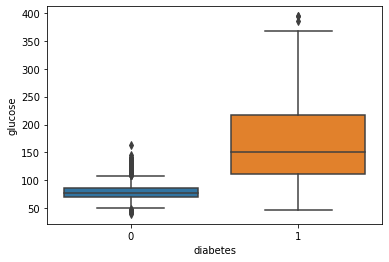

In [87]:
sns.boxplot(data=data,x='diabetes',y='glucose');

In [88]:
## Null handling for column glucose
data.loc[(data['glucose'].isna()) & (data['diabetes']==0) ,['glucose'] ]=data[data['diabetes']==0]['glucose'].median()
data.loc[(data['glucose'].isna()) & (data['diabetes']==1) ,['glucose'] ]=data[data['diabetes']==1]['glucose'].median()

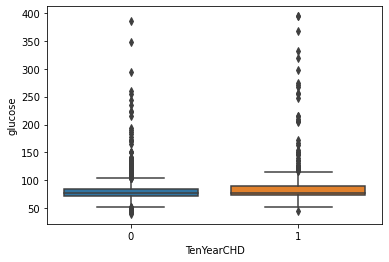

In [89]:
sns.boxplot(data=data,x='TenYearCHD',y='glucose');

Data Analysis

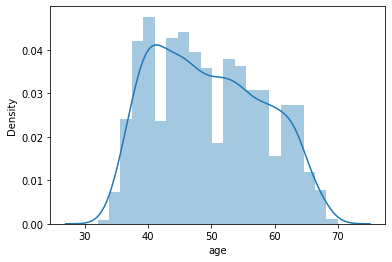

In [90]:
sns.distplot(data['age']);

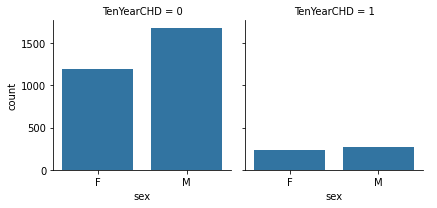

In [91]:
fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'sex').add_legend()
# show the object
plt.show()

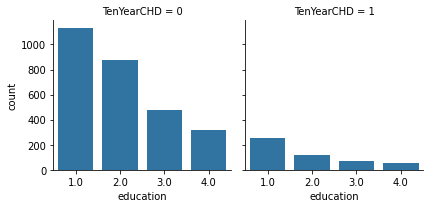

In [92]:

fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'education').add_legend()
# show the object
plt.show()

In [93]:
data['education'].describe()

count    3303.000000
mean        1.970936
std         1.019081
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: education, dtype: float64

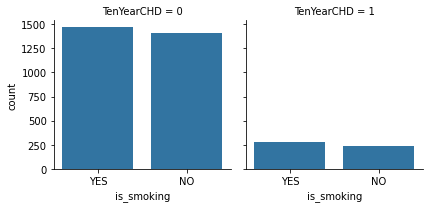

In [94]:
fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'is_smoking').add_legend()
# show the object
plt.show()

In [95]:
data['prevalentStroke'].describe()

count    3390.000000
mean        0.006490
std         0.080309
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: prevalentStroke, dtype: float64

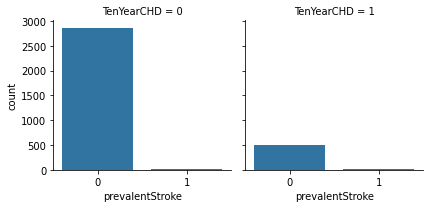

In [96]:
fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'prevalentStroke').add_legend()
# show the object
plt.show()

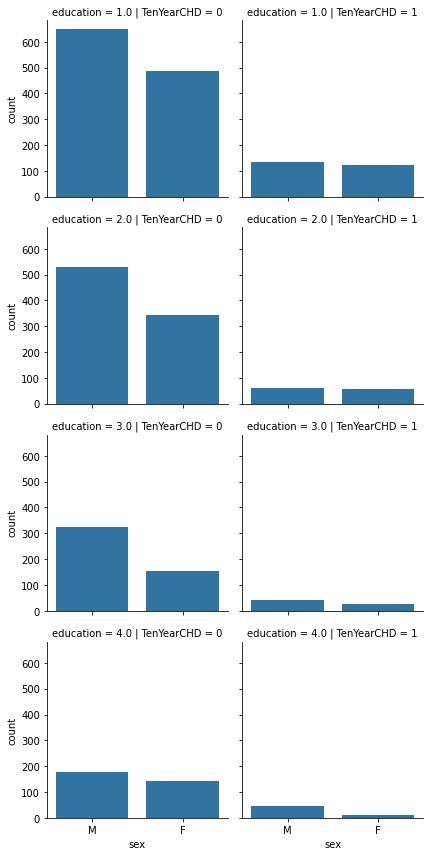

In [97]:
fct=sns.FacetGrid(data=data,col='TenYearCHD',row='education')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'sex').add_legend()
# show the object
plt.show()

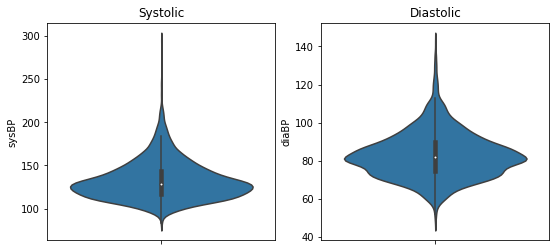

In [98]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
sns.violinplot(data=data,y='sysBP')
plt.title("Systolic")
plt.subplot(1,2,2)
sns.violinplot(data=data,y='diaBP',)
plt.title("Diastolic")
#plt.legends()
plt.show()

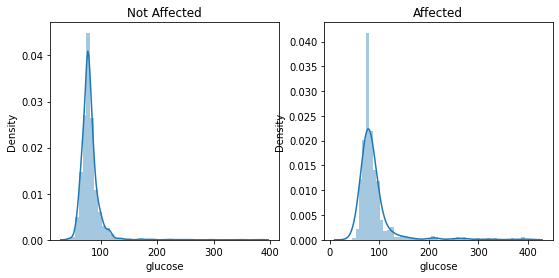

In [99]:
#sns.distplot(data['glucose']);
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
sns.distplot(data[data['TenYearCHD']==0]['glucose']);
plt.title("Not Affected")
plt.subplot(1,2,2)
sns.distplot(data[data['TenYearCHD']==1]['glucose']);
plt.title("Affected")
#plt.legends()
plt.show()

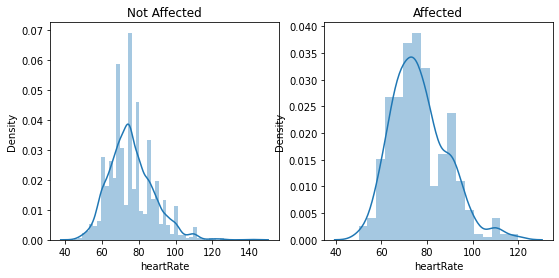

In [100]:
#sns.distplot(data['glucose']);
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
sns.distplot(data[data['TenYearCHD']==0]['heartRate']);
plt.title("Not Affected")
plt.subplot(1,2,2)
sns.distplot(data[data['TenYearCHD']==1]['heartRate']);
plt.title("Affected")
#plt.legends()
plt.show()

Handling Null Values

In [101]:
# Imputed null values with mode
data['BPMeds']=data['BPMeds'].fillna(s.mode(data['BPMeds']))

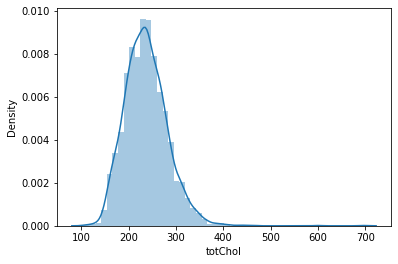

In [102]:
sns.distplot(data['totChol']);

In [103]:
# Less than 400 almost Normal, impute with mean
data['totChol']=data['totChol'].fillna(np.mean(data[data['totChol']<=400]['totChol']))

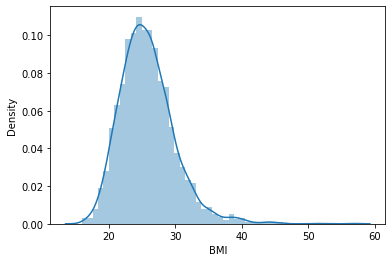

In [104]:
sns.distplot(data['BMI']);

In [105]:
# Less than 36 almost Normal, impute with mean
data['BMI']=data['BMI'].fillna(np.mean(data[data['BMI']<=36]['BMI']))

In [106]:
## CigsPerDay 22 nulls needs imputation as is_smoking is yes all 22 records
data[(data.cigsPerDay.isna()) & (data.is_smoking!='YES')]

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD


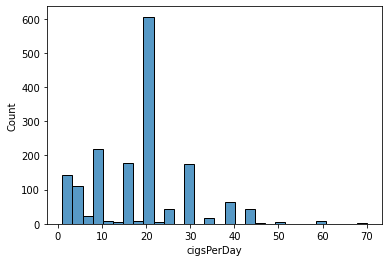

In [107]:
#data['cigsPerDay'].value_counts()

sns.histplot(data[data['cigsPerDay']!=0]['cigsPerDay'],bins=30);
## Bar plot gives an idea about what count of cigsperday is observed in more numbers

In [108]:
data['cigsPerDay']=data['cigsPerDay'].fillna(np.random.randint(5,30))

In [109]:
data['heartRate']=data['heartRate'].fillna(np.mean(data['heartRate']))

In [110]:
data.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,25.500835,90.0,80.0,1
1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.770000,72.0,75.0,0
2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.350000,88.0,94.0,0
3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.260000,68.0,94.0,1
4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.420000,70.0,77.0,0


In [111]:
# Encoding this categorical to prepare data for KNN impute
data['is_smoking']=data['is_smoking'].apply(lambda x:1 if x=='YES' else 0)
data['sex']=data['sex'].apply(lambda x:1 if x=='M' else 0)

In [112]:
#data.drop(['glucose'],inplace=True,axis=1)

In [113]:
data.isna().sum()

age                 0
education          87
sex                 0
is_smoking          0
cigsPerDay          0
BPMeds              0
prevalentStroke     0
prevalentHyp        0
diabetes            0
totChol             0
sysBP               0
diaBP               0
BMI                 0
heartRate           0
glucose             0
TenYearCHD          0
dtype: int64

In [114]:
#data[data['glucose'].isna()]
# define imputer
imputer = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')

In [115]:
# fit on the dataset
imputer.fit(data)

KNNImputer(n_neighbors=10)

In [116]:
# transform the dataset
data_trans = pd.DataFrame(imputer.transform(data),columns=data.columns)

In [117]:
data_trans.isna().sum().sum()

0

In [118]:
data=data_trans.copy()

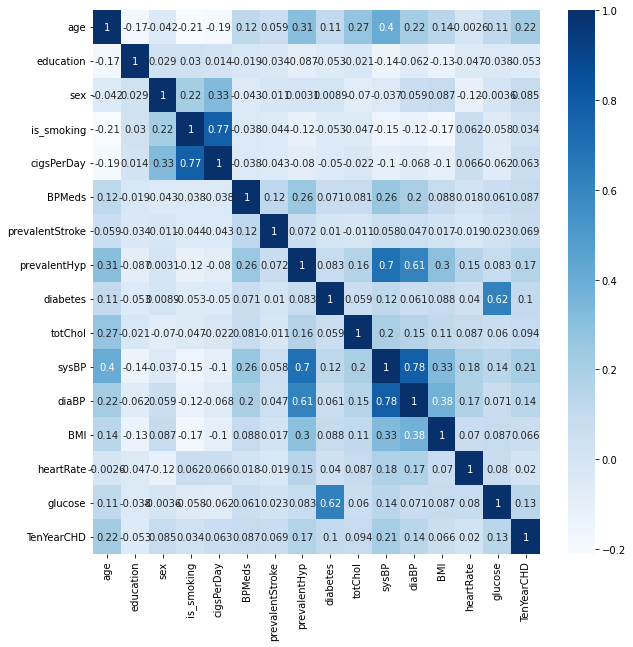

In [119]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True,cmap='Blues');

In [120]:

X=data.drop(['TenYearCHD'],axis=1).values
y=data['TenYearCHD'].values

In [121]:
# handling data imbalance
oversampler= sv.distance_SMOTE()
X_msmote, y_msmote= oversampler.sample(X, y)

2021-12-23 06:19:18,111:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


In [122]:
data_new=pd.DataFrame(X_msmote,columns=data.columns[:-1])
data_new['TenYearCHD']=pd.DataFrame(y_msmote)
data_new['TenYearCHD'].value_counts()

0.0    2879
1.0    2879
Name: TenYearCHD, dtype: int64

In [123]:
X=data_new.drop(['TenYearCHD'],axis=1)
y=data_new['TenYearCHD']

In [124]:
#X.drop(['is_smoking','education'],axis=1,inplace=True)

In [125]:
X['pulse']=X['sysBP']-X['diaBP']
X.drop(['sysBP','diaBP'],axis=1,inplace=True)

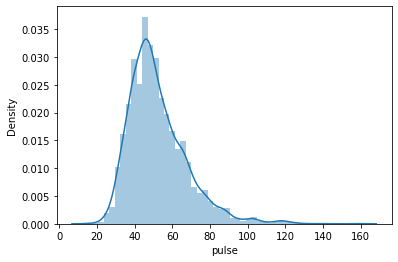

In [126]:
sns.distplot(X['pulse'])

In [127]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=10)

In [128]:

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [129]:
## Define the logistic model
logistic = LogisticRegression(random_state=30)

In [130]:
scoring = ['roc_auc']
scores = cross_validate(logistic,X, y, scoring = scoring, cv = 5, return_train_score=True,return_estimator=True,verbose = 10);

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] START .....................................................................
[CV] END ................. roc_auc: (train=0.703, test=0.697) total time=   0.1s
[CV] START .....................................................................
[CV] END ................. roc_auc: (train=0.708, test=0.685) total time=   0.1s
[CV] START .....................................................................
[CV] END ................. roc_auc: (train=0.701, test=0.705) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


[CV] END ................. roc_auc: (train=0.701, test=0.709) total time=   0.2s
[CV] START .....................................................................
[CV] END ................. roc_auc: (train=0.702, test=0.702) total time=   0.2s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


In [131]:
scores

{'estimator': [LogisticRegression(random_state=30),
  LogisticRegression(random_state=30),
  LogisticRegression(random_state=30),
  LogisticRegression(random_state=30),
  LogisticRegression(random_state=30)],
 'fit_time': array([0.13642764, 0.13815069, 0.12827611, 0.15960813, 0.14557743]),
 'score_time': array([0.00545812, 0.00548482, 0.00523019, 0.00517035, 0.00524879]),
 'test_roc_auc': array([0.69718424, 0.68526054, 0.70510224, 0.70906401, 0.70191425]),
 'train_roc_auc': array([0.70305831, 0.70762786, 0.70079654, 0.70076791, 0.70193637])}

In [132]:
logistic.fit(X_train,y_train)

LogisticRegression(random_state=30)

In [133]:
# Get the predicted class
train_preds = logistic.predict(X_train)
test_preds = logistic.predict(X_test)
cm = confusion_matrix(y_test, test_preds)
print(cm)

[[471 266]
 [199 504]]


In [134]:
## Calc Precision and recall


roc_auc = roc_auc_score(y_test, test_preds)
print(roc_auc)
precision = precision_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)
print("Precision")
print(precision)
print("Recall")
print(recall)
print("F1-Score")
print(2*precision*recall/(recall+precision))

0.6780023971697184
Precision
0.6545454545454545
Recall
0.716927453769559
F1-Score
0.6843177189409368


In [135]:
# Get the predicted probabilities
train_preds = logistic.predict_proba(X_train)
test_preds = logistic.predict_proba(X_test)

train_preds_df=pd.DataFrame(train_preds,columns=['No','Yes'])
train_preds=np.array(train_preds_df['Yes'])

test_preds_df=pd.DataFrame(test_preds,columns=['No','Yes'])
test_preds=np.array(test_preds_df['Yes'])

Best Threshold=0.517624, G-Mean=0.683
  


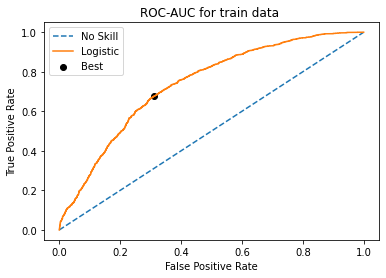

In [136]:
## Calculate optimal threshold using roc_curve method
fpr, tpr, thresholds = roc_curve(y_train, train_preds)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
print("  ")
plt.title("ROC-AUC for train data ")
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='Logistic')# marker='.'
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [137]:
test_preds_new=np.array(test_preds_df['Yes'].apply(lambda x:1 if x>=thresholds[ix] else 0))
test_preds_new=np.array(test_preds_df['Yes'].apply(lambda x:1 if x>=thresholds[ix] else 0))

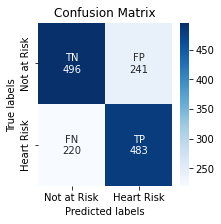

In [138]:
# Get the confusion matrix for test
plt.figure(figsize=(3,3))
labels = ['Not at Risk','Heart Risk' ]
#cm = confusion_matrix(y_test, test_preds_new)
cm = confusion_matrix(y_test, test_preds_new)

cat = ['TN','FP','FN','TP']
#cat = np.asarray(labels2).reshape(2,2)
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot()
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

In [139]:
## Calc Precision and recall
roc_auc = roc_auc_score(y_test, test_preds_new)
print(roc_auc)
precision = precision_score(y_test, test_preds_new)
recall = recall_score(y_test, test_preds_new)
print(precision)
print("\n")
print(recall)
print("F1-Score")
print(2*precision*recall/(recall+precision))

0.680027059838529
0.6671270718232044


0.6870554765291608
F1-Score
0.6769446391030134


In [140]:
############# Tuning

In [141]:
grid={
'C':[100, 10, 5,1.0, 0.1, 0.01],
'penalty':['none', 'l1', 'l2', 'elasticnet'],
'solver':['newton-cg', 'lbfgs', 'sag', 'saga']
}
logistic = LogisticRegression(random_state=10)

In [142]:

grid_search = GridSearchCV(estimator=logistic, param_grid=grid, n_jobs=-1, scoring='roc_auc',cv=5,error_score=0)
grid_result = grid_search.fit(X_train, y_train)
#grid_result = GridSearchCV(estimator=logistic, param_grid=grid, n_jobs=-1, scoring=weighted_f1_score,error_score="raise").fit(X, y)

In [143]:
# import sklearn
# print(sorted(sklearn.metrics.SCORERS.keys()))

In [144]:
#grid_result.cv_results_.keys()
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [145]:
C=grid_result.best_params_['C']
penalty=grid_result.best_params_['penalty']
solver=grid_result.best_params_['solver']
grid_result.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}

In [146]:
tuned_logistic=LogisticRegression(C=C, penalty=penalty,solver=solver,random_state=1)
tuned_logistic.fit(X_train,y_train)

LogisticRegression(C=0.01, random_state=1)

In [147]:
# Get the predicted probabilities
train_preds = tuned_logistic.predict(X_train)
test_preds = tuned_logistic.predict(X_test)

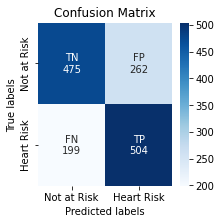

In [150]:
# Get the confusion matrix for test
plt.figure(figsize=(3,3))
labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, test_preds)

cat = ['TN','FP','FN','TP']
#cat = np.asarray(labels2).reshape(2,2)
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot()
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

In [152]:
## Calc Precision and recall
roc_auc = roc_auc_score(y_test, test_preds_new)
print(roc_auc)
print("")

precision = precision_score(y_test, test_preds_new)
recall = recall_score(y_test, test_preds_new)
print("Precision")
print(precision)
print("Recall")
print(recall)
print(2*precision*recall/(recall+precision))
print("")
accuracy = accuracy_score(y_test, test_preds_new)
print(accuracy)

0.680027059838529

Precision
0.6671270718232044
Recall
0.6870554765291608
0.6769446391030134

0.6798611111111111


# Support Vector Classifier

In [153]:
clf = SVC(kernel='rbf', C=1E6,random_state=1)
clf.fit(X_train, y_train)

SVC(C=1000000.0, random_state=1)

In [154]:
y_pred_svc=clf.predict(X_test)

In [155]:
cm = confusion_matrix(y_test, y_pred_svc)
print(cm)

[[601 136]
 [ 83 620]]


In [156]:
precision = precision_score(y_test, y_pred_svc)
recall = recall_score(y_test, y_pred_svc)
print(precision)
print(recall)
print(2*precision*recall/(recall+precision))
print("")
accuracy = accuracy_score(y_test, y_pred_svc)
print(accuracy)

0.8201058201058201
0.8819345661450925
0.8498971898560659

0.8479166666666667


In [157]:
clf = SVC(kernel='rbf', C=1E6,random_state=1,probability=True)
clf.fit(X_train, y_train)

SVC(C=1000000.0, probability=True, random_state=1)

In [158]:
train_preds=clf.predict_proba(X_train)
test_preds=clf.predict_proba(X_test)

In [159]:
## Calc threshold from training data
train_preds_df=pd.DataFrame(train_preds,columns=['No','Yes'])
train_preds=np.array(train_preds_df['Yes'])

## For test data
test_preds_df=pd.DataFrame(test_preds,columns=['No','Yes'])
test_preds=np.array(test_preds_df['Yes'])

In [160]:
train_preds

array([6.74286910e-01, 7.85961065e-01, 1.39250431e-05, ...,
       7.45782952e-04, 6.31071181e-01, 1.32772128e-01])

Best Threshold=0.519336, G-Mean=1.000


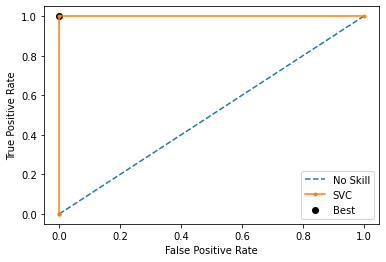

In [161]:
## Calculate optimal threshold using roc_curve method
fpr, tpr, thresholds = roc_curve(y_train, train_preds)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))


# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='SVC' , marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [162]:
train_preds_new=np.array(train_preds_df['Yes'].apply(lambda x:1 if x>thresholds[ix] else 0))
test_preds_new=np.array(test_preds_df['Yes'].apply(lambda x:1 if x>thresholds[ix] else 0))

[Text(0, 0.5, 'Not at Risk'), Text(0, 1.5, 'Heart Risk')]

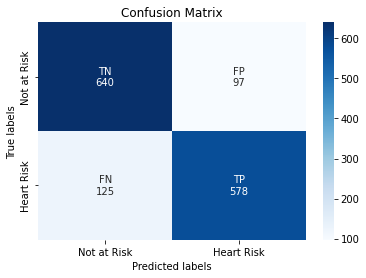

In [163]:
# Get the confusion matrix for test

labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, test_preds_new)

cat = ['TN','FP','FN','TP']
#cat = np.asarray(labels2).reshape(2,2)
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot()
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [164]:
precision = precision_score(y_test, test_preds_new)
recall = recall_score(y_test, test_preds_new)
print(precision)
print(recall)
print(2*precision*recall/(recall+precision))
print("")
accuracy = accuracy_score(y_test, test_preds_new)
print(accuracy)

0.8562962962962963
0.8221906116642959
0.8388969521044992

0.8458333333333333


In [165]:
train_preds_class=clf.predict(X_train)
test_preds_class=clf.predict(X_test)
cm = confusion_matrix(y_test, test_preds_class)
cm

array([[601, 136],
       [ 83, 620]])

In [166]:
precision = precision_score(y_test, test_preds_class)
recall = recall_score(y_test, test_preds_class)
print(precision)
print(recall)
print(2*precision*recall/(recall+precision))
print("")
accuracy = accuracy_score(y_test, test_preds_class)
print(accuracy)

0.8201058201058201
0.8819345661450925
0.8498971898560659

0.8479166666666667


# Bagging Classifier

In [168]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier

In [169]:
# define models and parameters
model = BaggingClassifier()
n_estimators = [50, 100,500, 1000]
# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.946003 using {'n_estimators': 500}
0.944822 (0.003306) with: {'n_estimators': 50}
0.945442 (0.004903) with: {'n_estimators': 100}
0.946003 (0.004888) with: {'n_estimators': 500}
0.945525 (0.004830) with: {'n_estimators': 1000}


In [170]:
grid_result.best_params_

{'n_estimators': 500}

In [171]:
clf_bag=BaggingClassifier(n_estimators=grid_result.best_params_['n_estimators'],random_state=10).fit(X_train,y_train)
y_pred_bag=clf_bag.predict(X_test)

In [172]:
cm = confusion_matrix(y_test, y_pred_bag)
print(cm)

[[717  20]
 [118 585]]


In [173]:
precision = precision_score(y_test, y_pred_bag)
recall = recall_score(y_test, y_pred_bag)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print ("F1-Score {:.3f}".format(2*precision*recall/(recall+precision)))
accuracy =accuracy_score(y_test, y_pred_bag)
print(accuracy)

Precision: 0.967
Recall: 0.832
F1-Score 0.894
0.9041666666666667


Bagging with Logistic

In [174]:
base1 = LogisticRegression(random_state=10)
base2 = LogisticRegression(C=10.0,penalty='l2',random_state=30, solver='lbfgs',)


In [175]:
X_train.shape

(4318, 14)

In [177]:
clf_bag_log1=BaggingClassifier(base_estimator=base1,n_estimators=500,max_samples=3000,random_state=10,bootstrap_features=True,oob_score=True).fit(X_train,y_train)
#clf_bag_log1=BaggingClassifier(base_estimator=base1,n_estimators=500,max_samples=3000,random_state=10,bootstrap_features=True,warm_start=True).fit(X_train,y_train)
y_pred_bag1=clf_bag_log1.predict(X_test)
cm = confusion_matrix(y_test, y_pred_bag1)
print(cm)

## Metrics
precision = precision_score(y_test, y_pred_bag1)
recall = recall_score(y_test, y_pred_bag1)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print ("F1-Score {:.3f}".format(2*precision*recall/(recall+precision)))
accuracy =accuracy_score(y_test, y_pred_bag1)
print(accuracy)

[[470 267]
 [205 498]]
Precision: 0.651
Recall: 0.708
F1-Score 0.678
0.6722222222222223
